I am going to build a Large Language model and yeah ..that's it

#1.EDA


In [ ]:
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.9.0+cu126
tiktoken version: 0.12.0


In [ ]:
import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)

In [ ]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [ ]:
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader

class TextdatasetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
        return len(self.input_ids)

  def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [ ]:
 def __len__(self):
        return len(self.input_ids)

 def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


In [ ]:

def create_dataloader_v1(txt, batch_size, max_length, stride,
                         shuffle=True, drop_last=True, num_workers=0):

    tokenizer = tiktoken.get_encoding("gpt2")

    dataset = TextdatasetV1atasetV1(txt, tokenizer, max_length, stride)


    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


In [ ]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

vocab_size = 50257
output_dim = 256
context_length = 1024


token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

def create_dataloader_v1(txt, batch_size, max_length, stride,
                         shuffle=True, drop_last=True, num_workers=0):

    tokenizer = tiktoken.get_encoding("gpt2")

    # Corrected typo here
    dataset = TextdatasetV1(txt, tokenizer, max_length, stride)


    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

batch_size = 8
max_length = 4
dataloader = create_dataloader_v1(
    raw_text,
    batch_size=batch_size,
    max_length=max_length,
    stride=max_length
)

In [ ]:

 for batch in dataloader:
  x,y = batch

  token_embeddingd=token_embedding_layer(x)
  pos_embeddings=pos_embedding_layer(torch.arange(max_length))

  input_embeddings=token_embeddingd+pos_embeddings

  break

In [ ]:
print(input_embeddings.shape)

torch.Size([8, 4, 256])


#1.Attention Mechanisms

multi head attention

In [ ]:
import torch
import torch.nn as nn

class CausalSelfAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
    super().__init__()
    self.d_out = d_out
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout)

    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

  def forward(self, x):
    b, n_tokens, d_in = x.shape
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    attn_scores = queries @ keys.transpose(1, 2)
    attn_scores.masked_fill_(self.mask[:n_tokens, :n_tokens], -torch.inf)
    attn_weights = torch.softmax(attn_scores / (keys.shape[-1]**0.5), dim=-1)
    attn_weights = self.dropout(attn_weights)

    context_vec = attn_weights @ values
    return context_vec

class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    self.num_heads = num_heads
    self.d_out = d_out
    self.heads = nn.ModuleList(
        [CausalSelfAttention(d_in, d_out, context_length, dropout, qkv_bias)
         for _ in range(num_heads)]
    )
    self.out_proj = nn.Linear(num_heads * d_out, d_out)

  def forward(self, x):

    context_vecs = torch.cat([head(x) for head in self.heads], dim=-1)

    return self.out_proj(context_vecs)

In [ ]:
torch.manual_seed(123)

d_in = output_dim
d_out = output_dim
num_heads = 8
context_length = max_length
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads)

batch = input_embeddings
context_vecs = mha(batch)

print("context_vecs.shape:", context_vecs.shape)


context_vecs.shape: torch.Size([8, 4, 256])


Implementing the GPT text to generate words

In [ ]:
import torch.nn as nn
import torch

class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps=1e-5
    self.scale=nn.Parameter(torch.ones(emb_dim))
    self.shift=nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean=x.mean(dim=-1,keepdim=True)
    var=x.var(dim=-1,keepdim=True,unbiased=False)
    norm_x=(x-mean)/torch.sqrt(var+self.eps)
    return self.scale*norm_x+self.shift

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5 * x * (1+torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi))*
        (x+0.044715 * torch.pow(x,3))
    ))

In [ ]:
class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),
        GELU(),
        nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"])
    )

  def forward(self,x):
    return self.layers(x)

class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.att=MultiHeadAttention(
        d_in=cfg["emb_dim"],
        d_out=cfg["emb_dim"],
        context_length=cfg["context_length"],
        num_heads=cfg["n_heads"],
        dropout=cfg["drop_rate"],
        qkv_bias=cfg["qkv_bias"]
    )

    self.ff=FeedForward(cfg)
    self.norm1=LayerNorm(cfg["emb_dim"])
    self.norm2=LayerNorm(cfg["emb_dim"])
    self.drop_shortcut=nn.Dropout(cfg["drop_rate"])

  def forward(self,x):

    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut


    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    return x

In [ ]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

  def generate_text_Simple(self, idx, max_new_tokens, context_length):
    for _ in range(max_new_tokens):
      idx_cond = idx[:, -context_length:]

      with torch.no_grad():
        logits = self(idx_cond)


      logits = logits[:, -1, :]
      idx_next = torch.argmax(logits, dim=-1, keepdim=True)
      idx = torch.cat((idx, idx_next), dim=-1)

    return idx

In [ ]:
import tiktoken
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps=1e-5
    self.scale=nn.Parameter(torch.ones(emb_dim))
    self.shift=nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean=x.mean(dim=-1,keepdim=True)
    var=x.var(dim=-1,keepdim=True,unbiased=False)
    norm_x=(x-mean)/torch.sqrt(var+self.eps)
    return self.scale*norm_x+self.shift

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5 * x * (1+torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi))*
        (x+0.044715 * torch.pow(x,3))
    ))

def main():
  GPT_CONFIG_124M={
    "vocab_size": 50257,
        "context_length": 1024,
        "emb_dim": 768,
        "n_heads": 12,
        "n_layers": 12,
        "drop_rate": 0.1,
        "qkv_bias": False
  }

  torch.manual_seed(123)
  model=GPTModel(GPT_CONFIG_124M)
  model.eval()

  start_context="Hello, I am"

  tokenizer=tiktoken.get_encoding("gpt2")
  encoded=tokenizer.encode(start_context)
  encoded_tensor=torch.tensor(encoded).unsqueeze(0)

  print(f"\n{50*'='}\n{22*' '}IN\n{50*'='}")
  print("\nInput text:", start_context)
  print("Encoded input text:", encoded)
  print("encoded_tensor.shape:", encoded_tensor.shape)

  out=model.generate_text_Simple(
      idx=encoded_tensor,
      max_new_tokens=10,
      context_length=GPT_CONFIG_124M["context_length"]
  )

  decoded_text=tokenizer.decode(out.squeeze(0).tolist())
  print(f"\n\n{50*'='}\n{22*' '}OUT\n{50*'='}")
  print("\nOutput:", out)
  print("Output length:", len(out[0]))
  print("Output text:", decoded_text)


if __name__ == "__main__":
    main()


                      IN

Input text: Hello, I am
Encoded input text: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


                      OUT

Output: tensor([[15496,    11,   314,   716,  1686, 17362, 37021,  6805, 33311, 40953,
         29515, 46248,  6723,  5409]])
Output length: 14
Output text: Hello, I amaps BaseballEdge components Keeping loosenetsksomeone SS decide


In [ ]:
import matplotlib.pyplot as plt
import os
import requests
import torch
import tiktoken


In [ ]:
from  llms_from_scratch.ch04 import GPTModel

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [ ]:
import torch
import torch.nn.functional as F
# Import the generate function from the llms_from_scratch library
from llms_from_scratch.ch05 import generate

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())


def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
       token_ids = generate(
           model=model, # Use the imported generate function
           idx=encoded,
           max_new_tokens=50,
           context_size=context_size,
           eos_id=tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})[0] # Pass the end-of-sequence token ID
       )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [ ]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen = 0
    global_step = -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


In [ ]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots()

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.show() # Ensure plt.show() is called


def main(gpt_config, settings):

    torch.manual_seed(123)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    file_path = "the-verdict.txt"
    url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

    if not os.path.exists(file_path):
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        text_data = response.text
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    # Model initialization
    model = GPTModel(gpt_config)
    model.to(device)

    # Optimizer setup
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=settings["learning_rate"], weight_decay=settings["weight_decay"]
    )

    # Dataloader creation
    train_ratio = 0.90
    split_idx = int(train_ratio * len(text_data))

    train_loader = create_dataloader_v1(
        text_data[:split_idx],
        batch_size=settings["batch_size"],
        max_length=gpt_config["context_length"],
        stride=gpt_config["context_length"],
        drop_last=True,
        shuffle=True,
        num_workers=0
    )

    val_loader = create_dataloader_v1(
        text_data[split_idx:],
        batch_size=settings["batch_size"],
        max_length=gpt_config["context_length"],
        stride=gpt_config["context_length"],
        drop_last=False,
        shuffle=False,
        num_workers=0
    )

    tokenizer = tiktoken.get_encoding("gpt2")

    # Training loop call
    train_losses, val_losses, tokens_seen = train_model_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=settings["num_epochs"], eval_freq=5, eval_iter=1,
        start_context="Every effort moves you", tokenizer=tokenizer
    )

    return train_losses, val_losses, tokens_seen, model

In [ ]:
import os
import requests

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

OTHER_SETTINGS = {
    "learning_rate": 5e-4,
    "num_epochs": 10,
    "batch_size": 2,
    "weight_decay": 0.1
}

gpt_config = GPT_CONFIG_124M
settings = OTHER_SETTINGS

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")


file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    text_data = response.text
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

model = GPTModel(gpt_config)
model.to(device)
optimizer = torch.optim.AdamW(
model.parameters(), lr=settings["learning_rate"], weight_decay=settings["weight_decay"]
    )

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))

train_loader = create_dataloader_v1(
        text_data[:split_idx],
        batch_size=settings["batch_size"],
        max_length=gpt_config["context_length"],
        stride=gpt_config["context_length"],
        drop_last=True,
        shuffle=True,
        num_workers=0
    )

val_loader = create_dataloader_v1(
        text_data[split_idx:],
        batch_size=settings["batch_size"],
        max_length=gpt_config["context_length"],
        stride=gpt_config["context_length"],
        drop_last=False,
        shuffle=False,
        num_workers=0
    )

Ep 1 (Step 000000): Train loss 9.984, Val loss 9.844
Ep 1 (Step 000005): Train loss 7.851, Val loss 8.043
Every effort moves you,,,,,,,,,,,,,,.                                   
Ep 2 (Step 000010): Train loss 6.271, Val loss 6.805
Ep 2 (Step 000015): Train loss 5.818, Val loss 6.575
Every effort moves you,.                                                
Ep 3 (Step 000020): Train loss 5.909, Val loss 6.546
Ep 3 (Step 000025): Train loss 5.587, Val loss 6.685
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
Ep 4 (Step 000030): Train loss 5.111, Val loss 6.525
Ep 4 (Step 000035): Train loss 5.315, Val loss 6.475
Every effort moves you-- a         "I a I had a I had to the--and-- I had to the of the"--as a--and a--and a--and a--and a-- I had a
Ep 5 (Step 000040): Train loss 4.600, Val loss 6.338
Every effort moves you, a, and, I had been. I had been. Gisburn, I had been, I had been, as, I h

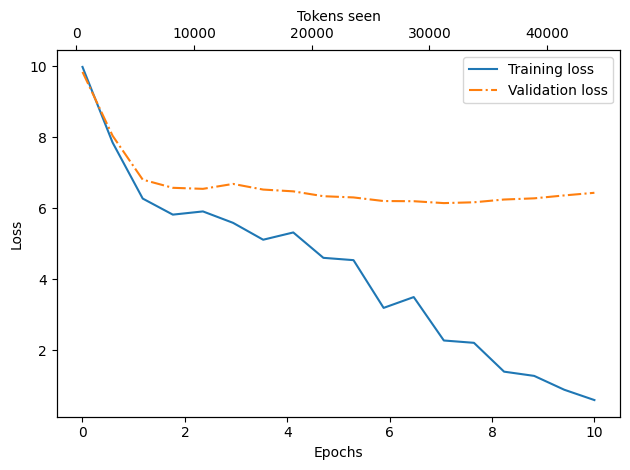

<Figure size 640x480 with 0 Axes>

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")


if __name__ == "__main__":

    GPT_CONFIG_124M = {
        "vocab_size": 50257,
        "context_length": 256,
        "emb_dim": 768,
        "n_heads": 12,
        "n_layers": 12,
        "drop_rate": 0.1,
        "qkv_bias": False
    }

    OTHER_SETTINGS = {
        "learning_rate": 5e-4,
        "num_epochs": 10,
        "batch_size": 2,
        "weight_decay": 0.1
    }



    train_losses, val_losses, tokens_seen, model = main(GPT_CONFIG_124M, OTHER_SETTINGS)



    # Plot results
    epochs_tensor = torch.linspace(0, OTHER_SETTINGS["num_epochs"], len(train_losses))
    plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
    plt.savefig("loss.pdf")

    # Save and load model
    torch.save(model.state_dict(), "model.pth")
    model = GPTModel(GPT_CONFIG_124M)
    model.load_state_dict(torch.load("model.pth", weights_only=True))


#Finetuning

In [ ]:
import requests
import zipfile
import os
from pathlib import Path
import time

import matplotlib.pyplot as plt
import pandas as pd
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
!pip install git+https://github.com/rasbt/LLMs-from-scratch.git


  Cloning https://github.com/rasbt/LLMs-from-scratch.git to /tmp/pip-req-build-y6ty55nx
  Running command git clone --filter=blob:none --quiet https://github.com/rasbt/LLMs-from-scratch.git /tmp/pip-req-build-y6ty55nx
  Resolved https://github.com/rasbt/LLMs-from-scratch.git to commit d85ba93799fcac69607ecf9fa554d22d0821fe20
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import llms_from_scratch


In [ ]:
from llms_from_scratch.ch05 import load_weights_into_gpt


In [ ]:
def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return


    response = requests.get(url, stream=True, timeout=60)
    response.raise_for_status()
    with open(zip_path, "wb") as out_file:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                out_file.write(chunk)


    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)


    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

In [ ]:
def create_balanced_dataset(df):

    num_spam = df[df["Label"] == "spam"].shape[0]

    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)


    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df


def random_split(df, train_frac, validation_frac):

    df = df.sample(frac=1, random_state=123).reset_index(drop=True)


    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)


    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

In [ ]:
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length == None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples


In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches



In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            examples_seen += input_batch.shape[0]  # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen




In [ ]:
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()



In [ ]:
if __name__ == "__main__":

    import argparse

    parser = argparse.ArgumentParser(
        description="Finetune a GPT model for classification"
    )
    parser.add_argument(
        "--test_mode",
        default=False,
        action="store_true",
        help=("This flag runs the model in test mode for internal testing purposes. "
              "Otherwise, it runs the model as it is used in the chapter (recommended).")
    )
    args = parser.parse_args([]) # Pass an empty list to ignore kernel arguments

    url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
    zip_path = "sms_spam_collection.zip"
    extracted_path = "sms_spam_collection"
    data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

    try:
        download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
    except (requests.exceptions.RequestException, TimeoutError) as e:
        print(f"Primary URL failed: {e}. Trying backup URL...")
        url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
        download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

    df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
    balanced_df = create_balanced_dataset(df)
    balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

    train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
    train_df.to_csv("train.csv", index=None)
    validation_df.to_csv("validation.csv", index=None)
    test_df.to_csv("test.csv", index=None)

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


In [ ]:
#dataloaders
tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

num_workers = 0
batch_size = 8

torch.manual_seed(123)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)


In [ ]:
!wget https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch05/01_main-chapter-code/gpt_download.py


--2025-12-28 10:51:39--  https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch05/01_main-chapter-code/gpt_download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5972 (5.8K) [text/plain]
Saving to: ‘gpt_download.py.1’

gpt_download.py.1   100%[===================>]   5.83K  --.-KB/s    in 0s      

2025-12-28 10:51:40 (108 MB/s) - ‘gpt_download.py.1’ saved [5972/5972]



In [ ]:
import urllib.request

url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch05/01_main-chapter-code/gpt_download.py"
urllib.request.urlretrieve(url, "gpt_download.py")


('gpt_download.py', <http.client.HTTPMessage at 0x7a992cf03b90>)

In [ ]:
pip install tensorflow tqdm


In [ ]:
from gpt_download import download_and_load_gpt2


settings, params = download_and_load_gpt2(model_size="355M", models_dir="gpt2")


checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 259kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 572kiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 216kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [05:52<00:00, 4.03MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 15.9MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:01<00:00, 626kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 360kiB/s]


In [ ]:
#pretrained model
if args.test_mode:
        BASE_CONFIG = {
            "vocab_size": 50257,
            "context_length": 120,
            "drop_rate": 0.0,
            "qkv_bias": False,
            "emb_dim": 12,
            "n_layers": 1,
            "n_heads": 2
        }
        model = GPTModel(BASE_CONFIG)
        model.eval()
        device = "cpu"

    # Code as it is used in the main chapter
else:
        CHOOSE_MODEL = "gpt2-small (124M)"
        INPUT_PROMPT = "Every effort moves"

        BASE_CONFIG = {
            "vocab_size": 50257,     # Vocabulary size
            "context_length": 1024,  # Context length
            "drop_rate": 0.0,        # Dropout rate
            "qkv_bias": True         # Query-key-value bias
        }

        model_configs = {
            "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
            "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
            "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
            "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
        }

        BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

        assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
            f"Dataset length {train_dataset.max_length} exceeds model's context "
            f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
            f"`max_length={BASE_CONFIG['context_length']}`"
        )

        model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
        settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

        model = GPTModel(BASE_CONFIG)
        load_weights_into_gpt(model, params)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 285kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 646kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 180kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [02:08<00:00, 3.88MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 7.98MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 466kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 452kiB/s]


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():

    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Device:", device)

model.to(device)

torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Device: cuda
Training accuracy: 0.00%
Validation accuracy: 0.00%
Test accuracy: 0.00%


In [ ]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 7.850
Validation loss: 8.022
Test loss: 7.682


In [ ]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [ ]:
for param in model.parameters():
    param.requires_grad = False

torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)
model.to(device)

for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [ ]:
#finetune modified model
start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 0.94 mi

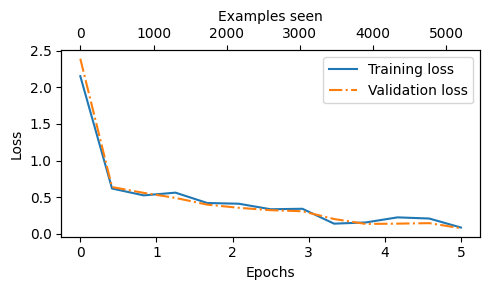

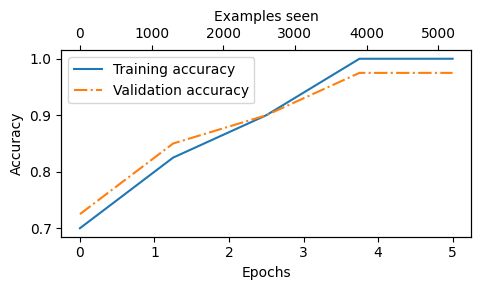

In [ ]:

    # loss plot
    epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
    examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
    plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

    # accuracy plot
    epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
    examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
    plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

#using the model as a spam classifier

In [ ]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()


    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]

    input_ids = input_ids[:min(max_length, supported_context_length)]
    assert max_length is not None, (
        "max_length must be specified. If you want to use the full model context, "
        "pass max_length=model.pos_emb.weight.shape[0]."
    )
    assert max_length <= supported_context_length, (
        f"max_length ({max_length}) exceeds model's supported context length ({supported_context_length})."
    )

    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [ ]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [ ]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [ ]:
torch.save(model.state_dict(), "review_classifier.pth")

In [ ]:
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

#finetuning for following instructions

In [ ]:
from importlib.metadata import version

pkgs = [
    "numpy",
    "matplotlib",
    "tiktoken",
    "torch",
    "tqdm",
    "tensorflow",
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

numpy version: 2.0.2
matplotlib version: 3.10.0
tiktoken version: 0.12.0
torch version: 2.9.0+cu126
tqdm version: 4.67.1
tensorflow version: 2.19.0


prepearingthe datasett


In [ ]:
import urllib
import json
import os

def download_and_load_file(file_path, url):

    try:
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
        print(f"Downloaded and saved file to {file_path}")
    except Exception as e:
        print(f"Error downloading or writing file: {e}")

        if not os.path.exists(file_path) or os.path.getsize(file_path) == 0:
            raise IOError(f"Could not download file and {file_path} is empty or does not exist locally.") from e
        else:
            print(f"Proceeding with existing (possibly old) file at {file_path} due to download error.")


    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "/content/instruction_data"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Downloaded and saved file to /content/instruction_data
Number of entries: 1100


In [ ]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [ ]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

data batches


In [ ]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [ ]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):

    batch_max_length = max(len(item)+1 for item in batch)


    inputs_lst = []

    for item in batch:
        new_item = item.copy()

        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )

        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)


    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [ ]:

inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [ ]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [ ]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [ ]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):

    batch_max_length = max(len(item)+1 for item in batch)


    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])


        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index


        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)


    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

dataloaders

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Device:", device)

Device: cuda


In [ ]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Device:", device)

from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

Device: cuda


In [ ]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [ ]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='cuda:0')


loading pre trained LLM

In [ ]:
from llms_from_scratch.ch04 import GPTModel
from llms_from_scratch.ch05 import download_and_load_gpt2, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


In [ ]:
!pip install git+https://github.com/rasbt/LLMs-from-scratch.git

  Cloning https://github.com/rasbt/LLMs-from-scratch.git to /tmp/pip-req-build-uf796166
  Running command git clone --filter=blob:none --quiet https://github.com/rasbt/LLMs-from-scratch.git /tmp/pip-req-build-uf796166
  Resolved https://github.com/rasbt/LLMs-from-scratch.git to commit d85ba93799fcac69607ecf9fa554d22d0821fe20
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [ ]:
from llms_from_scratch.ch05 import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)


token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [ ]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


finetuning the LLm on instruction data

In [ ]:
from llms_from_scratch.ch05 import (
   calc_loss_loader,
   train_model_simple,
 )

In [ ]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.825909376144409
Validation loss: 3.7619347095489504


In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.533, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.568, Val loss 0.729
Ep 1 (Step 000080): Train loss 0.604, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.710
Ep 1 (Step 000090): Train loss 0.563, Val loss

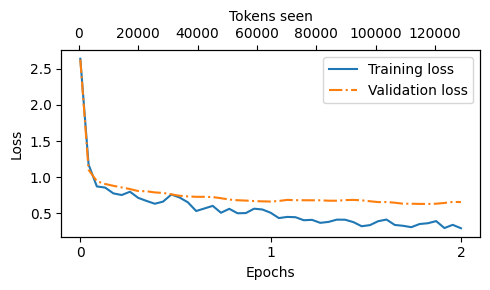

In [ ]:
from llms_from_scratch.ch05 import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

extracting and saving responses

In [ ]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prej

In [ ]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [01:13<00:00,  1.51it/s]


In [ ]:
import re


file_name = f"{re.sub(r'[ ()]', 'finetuned', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")


Model saved as gpt2-mediumfinetunedfinetuned355Mfinetuned-sft.pth


#finetune model on math physics and chemistry data

In [1]:
!curl -X GET \
     "https://datasets-server.huggingface.co/rows?dataset=shangzhu%2FChemQA&config=default&split=train&offset=0&length=100"

{"features":[{"feature_idx":0,"name":"image","type":{"_type":"Image"}},{"feature_idx":1,"name":"question","type":{"dtype":"string","_type":"Value"}},{"feature_idx":2,"name":"choices","type":{"dtype":"string","_type":"Value"}},{"feature_idx":3,"name":"label","type":{"dtype":"int64","_type":"Value"}},{"feature_idx":4,"name":"description","type":{"dtype":"string","_type":"Value"}},{"feature_idx":5,"name":"id","type":{"dtype":"string","_type":"Value"}}],"rows":[{"row_idx":0,"row":{"image":{"src":"https://datasets-server.huggingface.co/cached-assets/shangzhu/ChemQA/--/6ea68ad66560c5372a7a4f2aa7c0eb35056c8368/--/default/train/0/image/image.jpg?Expires=1766946756&Signature=uinH32baon12nMoY7WpQQdDb8rcLeI8Yo889ypiPtApIVvK8bNJa77srLxkBnpjLSuQCMTxIkHF~skn7EhEYR6wT~Z7Oz3JtY6RP1xlYYOd5YY4gpL-8bQjIsHuBytQ8I9CeINmIrY8yWikN5wBUNntILE~1avm6kgRLC1l10jPVurZiHMwBbbKzqwXWaoZpNt-qyThNIIKtwNp-phT8h8NH4wtxUJp4F0W2Amlc~gUa1tTYwXaL9ewSt8EBnzNoPptCv2Bj77MW0TbbwC661T-UwuDJLnezefQ0MemvpblcqQ2Oga6nrFxgltnQrQO8tOBGW

In [2]:
!curl -X GET \
     "https://datasets-server.huggingface.co/splits?dataset=shangzhu%2FChemQA"

{"splits":[{"dataset":"shangzhu/ChemQA","config":"default","split":"train"},{"dataset":"shangzhu/ChemQA","config":"default","split":"valid"},{"dataset":"shangzhu/ChemQA","config":"default","split":"test"}],"pending":[],"failed":[]}

In [3]:
!curl -X GET \
     "https://huggingface.co/api/datasets/shangzhu/ChemQA/parquet/default/train"

["https://huggingface.co/api/datasets/shangzhu/ChemQA/parquet/default/train/0.parquet","https://huggingface.co/api/datasets/shangzhu/ChemQA/parquet/default/train/1.parquet"]

In [9]:
from datasets import load_dataset

dataset = load_dataset("shangzhu/ChemQA", "default", split="train")
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/340M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/334M [00:00<?, ?B/s]

data/valid-00000-of-00001.parquet:   0%|          | 0.00/96.3M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/95.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/66166 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/9486 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9480 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'question', 'choices', 'label', 'description', 'id'],
    num_rows: 66166
})


In [17]:
from datasets import load_dataset

try:

    calculus_dataset = load_dataset("hendrycks/competition_math", "algebra", split="train") # Start with algebra, will check for calculus subsets
    print("Dataset 'hendrycks/competition_math' loaded successfully.")
    print(calculus_dataset)
    print(calculus_dataset[0])
except Exception as e:
    print(f"Error loading 'hendrycks/competition_math' dataset: {e}")
    print("Could not load 'hendrycks/competition_math'. Please consider another dataset or check the dataset name/config.")

Error loading 'hendrycks/competition_math' dataset: Dataset 'hendrycks/competition_math' doesn't exist on the Hub or cannot be accessed.
Could not load 'hendrycks/competition_math'. Please consider another dataset or check the dataset name/config.


In [18]:
from datasets import load_dataset

try:
    math_qa_dataset = load_dataset("math_qa", split="train")
    print("Dataset 'math_qa' loaded successfully.")
    print(math_qa_dataset)
    print(math_qa_dataset[0])
except Exception as e:
    print(f"Error loading 'math_qa' dataset: {e}")
    print("Could not load 'math_qa'. It might not be available or accessible.")

README.md: 0.00B [00:00, ?B/s]

math_qa.py: 0.00B [00:00, ?B/s]

Error loading 'math_qa' dataset: Dataset scripts are no longer supported, but found math_qa.py
Could not load 'math_qa'. It might not be available or accessible.


In [16]:
from datasets import load_dataset

try:
    calculus_dataset = load_dataset("deepmind/mathematics", "arithmetic__add_sub_multiple", split="train")
    print("Dataset 'deepmind/mathematics' loaded successfully.")
    print(calculus_dataset)
    print(calculus_dataset[0])
except Exception as e:
    print(f"Error loading 'deepmind/mathematics' dataset: {e}")
    print("Could not load 'deepmind/mathematics'. Please consider another dataset or check the dataset name/config.")

Error loading 'deepmind/mathematics' dataset: Dataset 'deepmind/mathematics' doesn't exist on the Hub or cannot be accessed.
Could not load 'deepmind/mathematics'. Please consider another dataset or check the dataset name/config.


In [10]:
from datasets import load_dataset

physics_dataset = load_dataset("camel-ai/physics", "default", split="train")
print(physics_dataset)

README.md: 0.00B [00:00, ?B/s]

physics.zip:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset({
    features: ['role_1', 'topic;', 'sub_topic', 'message_1', 'message_2'],
    num_rows: 20000
})


In [21]:
def format_calculus_input(entry):
    question = entry['question']
    cot = entry['CoT']
    response = entry['response']

    # Combining question and CoT for instruction, and response for the output
    # Assuming the model should generate the CoT first, then the final answer.
    # The 'response' field seems to contain the CoT + final answer already, but let's use CoT explicitly
    # and then the response.
    formatted_instruction = f"Question: {question}\nStep-by-step reasoning: {cot}"
    # The 'response' field in this dataset contains the final answer, and sometimes reiterates parts of the CoT
    formatted_response = f"Final Answer: {response}"

    # For this dataset, let's assume we want the model to generate the full CoT and then the final answer
    # So, the 'full_text' for training will be the question + CoT + response
    return formatted_instruction, formatted_response

# Split the calculus dataset
calculus_train_test_split = calculus_dataset.train_test_split(test_size=0.2, seed=42)
calculus_train_val_split = calculus_train_test_split['train'].train_test_split(test_size=0.1, seed=42)

calculus_train_data = calculus_train_val_split['train']
calculus_val_data = calculus_train_val_split['test']
calculus_test_data = calculus_train_test_split['test']

print(f"Calculus training examples: {len(calculus_train_data)}")
print(f"Calculus validation examples: {len(calculus_val_data)}")
print(f"Calculus test examples: {len(calculus_test_data)}")

Calculus training examples: 192
Calculus validation examples: 22
Calculus test examples: 54


In [30]:
# --- 5. Create a generic InstructionDataset and DataLoaders for the merged dataset ---

class MergedInstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = [tokenizer.encode(text) for text in self.data]

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

# Create DataLoaders for the merged dataset
# Assuming tokenizer, batch_size, num_workers, and customized_collate_fn are defined globally or in a preceding cell
merged_train_dataset = MergedInstructionDataset(merged_train_data, tokenizer)
merged_val_dataset = MergedInstructionDataset(merged_val_data, tokenizer)
merged_test_dataset = MergedInstructionDataset(merged_test_data, tokenizer)

merged_train_loader = DataLoader(
    merged_train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

merged_val_loader = DataLoader(
    merged_val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

merged_test_loader = DataLoader(
    merged_test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

print(f"\nMerged Train loader size: {len(merged_train_loader)}")
print(f"Merged Validation loader size: {len(merged_val_loader)}")
print(f"Merged Test loader size: {len(merged_test_loader)}")


Merged Train loader size: 8643
Merged Validation loader size: 1081
Merged Test loader size: 1081


In [29]:
import json
import random
from torch.utils.data import Dataset, DataLoader
import ast # Import the ast module

# --- 1. Define formatting functions for each dataset ---

def format_physics_entry(entry):
    instruction = f"Problem: {entry['message_1']}"
    response = f"Solution: {entry['message_2']}"
    return f"{instruction}\n{response}"

def format_chemqa_entry(entry):
    question = entry['question']
    choices_str = entry['choices']
    # Use ast.literal_eval for robust parsing of Python literal strings
    choices_list = ast.literal_eval(choices_str)
    label = entry['label']
    correct_choice = choices_list[label]

    instruction = f"Question: {question}\nChoices: {', '.join(choices_list)}"
    response = f"Answer: {correct_choice}"
    return f"{instruction}\n{response}"

def format_calculus_entry(entry):
    # Re-using the logic from the previous format_calculus_input function
    instruction = f"Question: {entry['question']}\nStep-by-step reasoning: {entry['CoT']}"
    response = f"Final Answer: {entry['response']}"
    return f"{instruction}\n{response}"


# --- 2. Process each dataset into the unified text format ---

# Process physics data
formatted_physics_data = [format_physics_entry(entry) for entry in physics_dataset]

# Process ChemQA data
formatted_chemqa_data = [format_chemqa_entry(entry) for entry in dataset] # 'dataset' is the ChemQA data

# Process calculus data
formatted_calculus_data = [format_calculus_entry(entry) for entry in calculus_dataset]


# --- 3. Combine all formatted data ---
all_formatted_data = formatted_physics_data + formatted_chemqa_data + formatted_calculus_data

print(f"Total combined formatted entries: {len(all_formatted_data)}")
print(f"Sample of combined data (Physics): {all_formatted_data[0][:200]}...")

# Adjust index for ChemQA sample, depending on physics_dataset size
chemqa_sample_index = len(formatted_physics_data)
print(f"Sample of combined data (ChemQA): {all_formatted_data[chemqa_sample_index][:200]}...")

# Adjust index for Calculus sample
calculus_sample_index = len(formatted_physics_data) + len(formatted_chemqa_data)
print(f"Sample of combined data (Calculus): {all_formatted_data[calculus_sample_index][:200]}...")


# --- 4. Split the combined data into train, validation, and test sets ---
random.seed(123) # for reproducibility
random.shuffle(all_formatted_data)

train_ratio = 0.8
val_ratio = 0.1

total_size = len(all_formatted_data)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
# Test size will be the rest to avoid off-by-one errors with int conversion
test_size = total_size - train_size - val_size

merged_train_data = all_formatted_data[:train_size]
merged_val_data = all_formatted_data[train_size:train_size + val_size]
merged_test_data = all_formatted_data[train_size + val_size:]

print(f"\nMerged Training examples: {len(merged_train_data)}")
print(f"Merged Validation examples: {len(merged_val_data)}")
print(f"Merged Test examples: {len(merged_test_data)}")

Total combined formatted entries: 86434
Sample of combined data (Physics): Problem: What is the probability of finding a particle with a given energy in a one-dimensional infinite square well potential when the potential width is 2 nm and the particle has a mass of 5x10^-26 ...
Sample of combined data (ChemQA): Question: What is the most relevant description of the following organic molecule?
Choices: The molecule is an aromatic ketone that is phenyl 1H-pyrazol-4-yl ketone in which the pyrazolyl group is sub...
Sample of combined data (Calculus): Question: Two students were asked to write an nth term for the sequence 1, 16, 81, 256, ... and to write the 5th term of the sequence. One student gave the nth term as \(u_n = n^4\). The other student...

Merged Training examples: 69147
Merged Validation examples: 8643
Merged Test examples: 8644


In [26]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import tiktoken # Import tiktoken for tokenizer
from functools import partial
import torch

tokenizer = tiktoken.get_encoding("gpt2") # Define tokenizer

# Define device here as it's needed for customized_collate_fn
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

# Re-defining custom_collate_fn and customized_collate_fn as they are dependencies
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):

    batch_max_length = max(len(item)+1 for item in batch)


    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])


        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index


        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)


    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

# Defining batch_size and num_workers again
batch_size = 8
num_workers = 0

class CalculusInstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            formatted_instruction, formatted_response = format_calculus_input(entry)
            full_text = formatted_instruction + "\n" + formatted_response
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)


# Create DataLoaders for calculus dataset
calculus_train_dataset = CalculusInstructionDataset(calculus_train_data, tokenizer)
calculus_val_dataset = CalculusInstructionDataset(calculus_val_data, tokenizer)
calculus_test_dataset = CalculusInstructionDataset(calculus_test_data, tokenizer)

calculus_train_loader = DataLoader(
    calculus_train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

calculus_val_loader = DataLoader(
    calculus_val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

calculus_test_loader = DataLoader(
    calculus_test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

print("Calculus Train loader size:", len(calculus_train_loader))
print("Calculus Validation loader size:", len(calculus_val_loader))
print("Calculus Test loader size:", len(calculus_test_loader))

Calculus Train loader size: 24
Calculus Validation loader size: 3
Calculus Test loader size: 7


In [20]:
from datasets import load_dataset

try:
    calculus_dataset = load_dataset("0xZee/dataset-CoT-Advanced-Calculus-268", split="train")
    print("Dataset '0xZee/dataset-CoT-Advanced-Calculus-268' loaded successfully.")
    print(calculus_dataset)
    print(calculus_dataset[0])
except Exception as e:
    print(f"Error loading '0xZee/dataset-CoT-Advanced-Calculus-268' dataset: {e}")
    print("Could not load the dataset. Please check the dataset name or if it requires specific authentication.")

README.md:   0%|          | 0.00/365 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/686k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/268 [00:00<?, ? examples/s]

Dataset '0xZee/dataset-CoT-Advanced-Calculus-268' loaded successfully.
Dataset({
    features: ['question', 'response', 'CoT'],
    num_rows: 268
})
{'question': 'Two students were asked to write an nth term for the sequence 1, 16, 81, 256, ... and to write the 5th term of the sequence. One student gave the nth term as \\(u_n = n^4\\). The other student, who did not recognize this simple law of formation, wrote \\(u_n = 10n^3 - 35n^2 + 50n - 24\\). Which student gave the correct 5th term?', 'response': 'If \\(u_n = n^4\\), then \\(u_1 = 1^4 = 1\\), \\(u_2 = 2^4 = 16\\), \\(u_3 = 3^4 = 81\\), \\(u_4 = 4^4 = 256\\), which agrees with the first four terms of the sequence. Hence the first student gave the 5th term as \\(u_5 = 5^4 = 625\\).\\n\\nIf \\(u_n = 10n^3 - 35n^2 + 50n - 24\\), then \\(u_1 = 1, u_2 = 16, u_3 = 81, u_4 = 256\\), which also agrees with the first four terms given. Hence, the second student gave the 5th term as \\(u_5 = 601\\).\\n\\nBoth students were correct. Merely gi

In [19]:
from huggingface_hub import HfApi

api = HfApi()
unique_datasets = set()
search_keywords = ["calculus", "math", "mathematics"]

print("Searching for datasets on Hugging Face Hub...")

for keyword in search_keywords:
    print(f"Searching for datasets with keyword: '{keyword}'...")
    try:
        found_datasets = api.list_datasets(search=keyword, full=False)
        for ds_info in found_datasets:
            unique_datasets.add(ds_info.id)
    except Exception as e:
        print(f"An error occurred while searching for '{keyword}': {e}")

if unique_datasets:
    print(f"\nFound {len(unique_datasets)} datasets potentially related to mathematics or calculus:")
    for ds_id in sorted(list(unique_datasets)): # Sort for consistent output
        print(ds_id)
else:
    print("No datasets found matching 'calculus', 'math', or 'mathematics' in their IDs.")
    print("You might want to manually search the Hugging Face Hub at https://huggingface.co/datasets with more specific queries or filter by tags.")

Streaming output truncated to the last 5000 lines.
math-extraction-comp/MaziyarPanahi__calme-2.2-rys-78b
math-extraction-comp/MaziyarPanahi__calme-2.3-llama3-70b
math-extraction-comp/MaziyarPanahi__calme-2.3-llama3.1-70b
math-extraction-comp/MaziyarPanahi__calme-2.3-phi3-4b
math-extraction-comp/MaziyarPanahi__calme-2.3-qwen2-72b
math-extraction-comp/MaziyarPanahi__calme-2.3-rys-78b
math-extraction-comp/MaziyarPanahi__calme-2.4-llama3-70b
math-extraction-comp/MaziyarPanahi__calme-2.4-rys-78b
math-extraction-comp/MaziyarPanahi__calme-3.1-instruct-78b
math-extraction-comp/ModelCloud__Llama-3.2-1B-Instruct-gptqmodel-4bit-vortex-v1
math-extraction-comp/MultivexAI__Phi-3.5-Mini-Instruct-MultiVex-v0.25-GGUF
math-extraction-comp/NAPS-ai__naps-llama-3_1-8b-instruct-v0.4
math-extraction-comp/NAPS-ai__naps-llama-3_1-instruct-v0.5.0
math-extraction-comp/NCSOFT__Llama-VARCO-8B-Instruct
math-extraction-comp/NLPark__B-and-W_Flycatcher-3AD1E
math-extraction-comp/NLPark__Shi-Ci-Robin-Test_3AD80
math-ex

In [11]:
!ls -R mathematics_dataset

mathematics_dataset:
example.py   generate_settings.py  generate_to_file.py	modules  util
generate.py  generate_test.py	   __init__.py		sample

mathematics_dataset/modules:
algebra.py	    calculus.py       measurement.py  probability.py
algebra_test.py     calculus_test.py  modules.py      train_test_split.py
arithmetic.py	    comparison.py     numbers.py
arithmetic_test.py  __init__.py       polynomials.py

mathematics_dataset/sample:
arithmetic.py	    linear_system.py	   number_test.py  polynomials.py
arithmetic_test.py  linear_system_test.py  ops.py	   polynomials_test.py
__init__.py	    number.py		   ops_test.py

mathematics_dataset/util:
combinatorics.py       composition_test.py  __init__.py
combinatorics_test.py  display.py	    probability.py
composition.py	       display_test.py	    probability_test.py


In [6]:
!curl -X GET \
     "https://datasets-server.huggingface.co/rows?dataset=camel-ai%2Fphysics&config=default&split=train&offset=0&length=100"

{"features":[{"feature_idx":0,"name":"role_1","type":{"dtype":"string","_type":"Value"}},{"feature_idx":1,"name":"topic;","type":{"dtype":"string","_type":"Value"}},{"feature_idx":2,"name":"sub_topic","type":{"dtype":"string","_type":"Value"}},{"feature_idx":3,"name":"message_1","type":{"dtype":"string","_type":"Value"}},{"feature_idx":4,"name":"message_2","type":{"dtype":"string","_type":"Value"}}],"rows":[{"row_idx":0,"row":{"role_1":"Physicist_RoleType.ASSISTANT","topic;":"Quantum mechanics","sub_topic":"The Schrödinger equation and its solutions","message_1":"What is the probability of finding a particle with a given energy in a one-dimensional infinite square well potential when the potential width is 2 nm and the particle has a mass of 5x10^-26 kg? Use the Schrödinger equation to solve for the allowed energy states and their wave functions.","message_2":"To find the probability of finding a particle with a given energy in a one-dimensional infinite square well potential, we first

In [7]:
!curl -X GET \
     "https://datasets-server.huggingface.co/splits?dataset=camel-ai%2Fphysics"

{"splits":[{"dataset":"camel-ai/physics","config":"default","split":"train"}],"pending":[],"failed":[]}

In [8]:
!curl -X GET \
     "https://huggingface.co/api/datasets/camel-ai/physics/parquet/default/train"

["https://huggingface.co/api/datasets/camel-ai/physics/parquet/default/train/0.parquet"]